In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / "PrISM_code"))

In [2]:
from PrISM_P20 import *
from PrISM_light import IRRI_PRISM_light
from plot_utils import make_nice_hist

/data/PhDGiovanni/5.IrriEst/CODE/GIT_prism/PrISM/PrISM_code/PrISM_light.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm as ntqdm


# Test to reproduce this plot: Fig.2 of [Pellarin et al., 2020](https://www.mdpi.com/2072-4292/12/3/481/htm)
<img style="float: left;" src="https://www.mdpi.com/remotesensing/remotesensing-12-00481/article_deploy/html/images/remotesensing-12-00481-g002-550.jpg" width="550px">

## INPUTS - For this test input data are approximated from the plot
    INPUTS: 
            Satellite Soil Moisture 
            Precipitation
    OUTPUTS:
            PRiSM SM

In [3]:
# Data every 3 hours - PRECIPITATION
ind = pd.date_range(start = '2015-09-16', end = '2015-09-21T06', freq = '3H')
prec = pd.DataFrame([
    0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , #16
    0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  13.5, #17
    30.5,  11.5,  6,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , #18
    0.  ,  0.  ,  0.  ,  0.  ,  1.9 ,  3.6,   0.  ,  0.  , #19
    0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , #20
    0.  ,  0.  ,  0.],                                     #21
    columns = ['P'],
    index = ind)
# 5 measurements of Soil Moisture
ind2 = pd.DatetimeIndex(['2015-09-16T06','2015-09-18T06','2015-09-19T06','2015-09-19T18','2015-09-21T06'])
smos_sm = pd.DataFrame([3.5, 10.5, 2.7, 9.5, 6.2],index = ind2, columns = ['P'])

#PARAMETERS
sm_sat = 35
sm_res = 3    # NOT SURE it is a guess
tau    = 60   # NOT SURE it is a guess
d_soil = 100   #[mm](Niger site)
dt = 3

### CALCULATE EVERYTHING

In [4]:
# caluculate PrISM with traditional method
sm_prism, prec_particle_filter, sm_prism_particle_filter, selected_trajectories, selected_prec, sm_prism_selected = apply_PrISM(
    prec, 
    smos_sm, 
    initial_sm = 4, 
    params_api = {'sm_res': sm_res, 'sm_sat': sm_sat,'tau': tau, 'd_soil': d_soil, 'dt':dt}
)

In [5]:
# calculate PrISM with new method (also considers moving window)
ip = IRRI_PRISM_light(precipitation=prec,
        satellite_sm=smos_sm,
        params_api = {'sm_res': sm_res, 'sm_sat': sm_sat,'tau': tau, 'd_soil': d_soil, 'dt':dt},
        window = 5,
        verbose = False)
ip.run()

### VISUALIZE Everything

(0.0, 60.0)

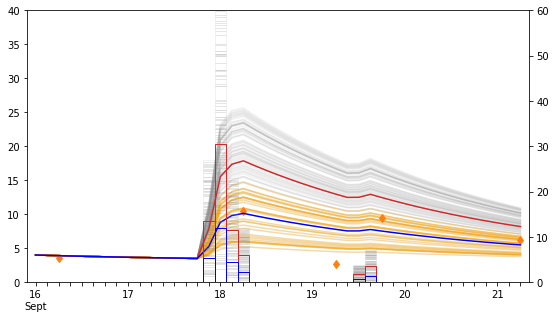

In [6]:
fig, ax = plt.subplots(figsize = (9,5))
#first y axis
ax  = sm_prism_particle_filter.plot(ax=ax, color = 'grey', legend = False, zorder = 10, alpha = 0.1, use_index=False)
ax  = sm_prism_particle_filter[selected_trajectories].plot(ax=ax, color = 'orange', legend = False, zorder = 15, alpha = 0.3, use_index=False)
ax  = sm_prism.plot(ax=ax, color = 'tab:red', style = '-', use_index=False, zorder = 20, legend = False)
ax  = sm_prism_selected.plot(ax=ax, color = 'blue', style = '-', use_index=False, zorder = 30, legend = False) 
ax  = smos_sm.reindex(sm_prism.index).plot(ax=ax, use_index=False, color = 'tab:orange', style = 'd',zorder = 25, legend = False)  

ax2 = ax.twinx()
# preparing visualization precipitation particle filter
prec_particle_filter2 = prec_particle_filter.diff(axis=1)
prec_particle_filter2.loc[:,prec_particle_filter2.columns[0]] = prec_particle_filter.loc[:,prec_particle_filter2.columns[0]]
#second y axis
ax2 = prec_particle_filter2.plot.bar(ax=ax2, width = 1, stacked = True, ec = 'grey', fc = "None", legend = False,
                                     zorder = 10, alpha = 0.1)
ax2 = prec.plot(kind = 'bar', ax=ax2,  ec = 'tab:red', fc = "None",
                width = 1, use_index=False, zorder = 20, legend = False) 
ax2 = selected_prec.plot.bar(ax=ax2, width = 1, ec = 'blue', fc = "None", legend = False,
                                     zorder = 30, alpha =1)

# ax.set_zorder(ax2.get_zorder()+1)
ax.set_frame_on(False)
el0 = prec_particle_filter.index.day[0]
newXticks = [f'{el0}\nSept']
for tt in prec_particle_filter.index.day[1::]:
    if tt!=el0:
        el0=tt
        newXticks.append(el0)
    else:
        newXticks.append('')
ticks = ax.set_xticklabels(newXticks)

ax.set_ylim(0,40)
ax2.set_ylim(0,60)

(0.0, 60.0)

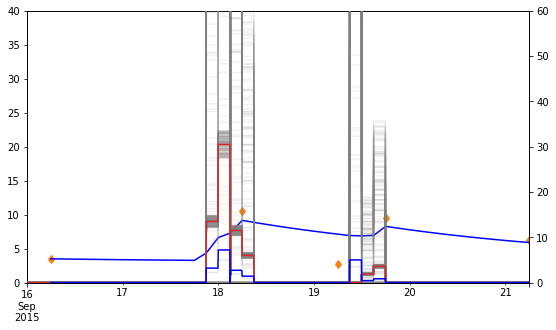

In [7]:
fig, ax = plt.subplots(figsize = (9,5))

make_nice_hist(ip.guess_max_perturbed).iloc[:,[0]].plot(ax=ax, legend = False, alpha = 0)
ax  = ip.est_sm_min.plot(ax=ax, color = 'blue', style = '-', zorder = 30, legend = False) 
ax  = ip.sat_sm.reindex(sm_prism.index).plot(ax=ax, color = 'tab:orange', style = 'd',zorder = 25, legend = False)  

ax2 = ax.twinx()
ip.est_sm_min.plot(ax=ax2, color = 'w', legend = False, alpha = 0) 
ax2 = make_nice_hist(ip.guess_max_perturbed, frequency_irr="3H").plot(ax=ax2, color = 'grey', legend = False, zorder = 10, alpha = 0.1)
make_nice_hist(ip.prec, frequency_irr="3H").plot(ax=ax2,  color = 'tab:red', zorder = 20, legend = False)
make_nice_hist(ip.est_irr_max, frequency_irr="3H").plot(ax=ax2,  color = 'blue', zorder = 30, legend = False)

ax.set_ylim(0,40)
ax2.set_ylim(0,60)